# Import libraries

In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.13.0


In [3]:
!pip install imagehash
!pip install seaborn

In [4]:
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from PIL import Image
import imagehash
from sklearn.model_selection import KFold
import zipfile

# Load and clean the dataset

In [5]:
# Load the data from the file
file_path = "/kaggle/input/public-data-zip/public_data.npz"
loaded_data = np.load(file_path, allow_pickle = True)

In [6]:
# Access the 'data' and 'labels' arrays
data = loaded_data['data']
labels = loaded_data['labels']

In [7]:
# 58 -> Shrek - 338 -> Trololo
to_extract = [data[58], data[338]]
outliers = []

for i, image in enumerate(to_extract):
    pil_image = Image.fromarray(image.astype('uint8'))
    img_hash = imagehash.average_hash(pil_image)

    outliers.append(img_hash)
    print(img_hash)

081c1e1e1e3f3f1b
02393d3e3c3c1c00


In [8]:
# Create a list to store unique hashes and their corresponding indices
hashes = []
unique_indices = []
raw_images = []
duplicates = []
duplicates_labels = []  # Assuming you have a list of labels for duplicate images
indices_duplicates = []

# Iterate through the images and calculate their perceptual hashes
for i, image in enumerate(data):
    pil_image = Image.fromarray(image.astype('uint8'))
    img_hash = imagehash.average_hash(pil_image)

    pil_image.info['label'] = labels[i]
    raw_images.append(pil_image)

    # Check if the hash is unique
    if img_hash not in hashes:
        hashes.append(img_hash)
        unique_indices.append(i)
    else:
        duplicates.append(np.array(pil_image))  # Convert PIL Image to NumPy array
        duplicates_labels.append(labels[i])
        indices_duplicates.append(i)

# Create a new numpy array with only the unique images
unique_data = data[unique_indices]

# Create a new numpy array with only the unique labels
unique_labels = labels[unique_indices]

# Save the cleaned dataset
np.savez('cleaned_data.npz', data=unique_data, labels=unique_labels)

# Image augmentation

In [9]:
# Load the data from the file
file_path = "/kaggle/working/cleaned_data.npz"
loaded_data = np.load(file_path, allow_pickle = True)

# Access the 'data' and 'labels' arrays
data = loaded_data['data']
labels = loaded_data['labels']

healthy = []
unhealthy = []

# Iterate through the images to separate them into the proper set
for i, image in enumerate(data):
    if labels[i] == 'unhealthy':
        unhealthy.append(image)
    else:
        healthy.append(image)

print(len(healthy))
print(len(unhealthy))

3061
1791


In [10]:
import numpy as np
from PIL import Image

dataset = healthy

def apply_rotations(image):
    angles = np.arange(0, 359,95)
    rotated_images = []
    for angle in angles:
        image = (image * 255).astype(np.uint8)
        
        rotated_image = Image.fromarray(image)
        rotated_image = rotated_image.rotate(angle)
        rotated_images.append(np.array(rotated_image))
    return rotated_images

# Apply rotations to the dataset
rotated_healthy = []
for image in dataset:
    rotated_images = apply_rotations(image)
    rotated_healthy.extend(rotated_images)

rotated_healthy = np.stack(rotated_healthy)

print(len(healthy))
print(len(rotated_healthy))

preprocessed_healthy = rotated_healthy

print(len(preprocessed_healthy))

3061
12244
12244


In [11]:
import numpy as np
from PIL import Image

dataset = unhealthy

def apply_rotations(image):
    angles = np.arange(0, 359, 55)
    rotated_images = []
    for angle in angles:
        image = (image * 255).astype(np.uint8)
        
        rotated_image = Image.fromarray(image)
        rotated_image = rotated_image.rotate(angle)
        rotated_images.append(np.array(rotated_image))
    return rotated_images

# Apply rotations to the dataset
rotated_unhealthy = []
for image in dataset:
    rotated_images = apply_rotations(image)
    rotated_unhealthy.extend(rotated_images)

rotated_unhealthy = np.stack(rotated_unhealthy)

print(len(unhealthy))
print(len(rotated_unhealthy))

preprocessed_unhealthy = rotated_unhealthy

print(len(preprocessed_unhealthy))


1791
12537
12537


In [12]:
# Concatenate the preprocessed sets
preprocessed_data = np.concatenate([preprocessed_healthy, preprocessed_unhealthy], axis=0)
augmented_data = preprocessed_data

augmented_labels_healthy = np.full((len(preprocessed_healthy),), 'healthy', dtype='object')
augmented_labels_unhealthy = np.full((len(preprocessed_unhealthy),), 'unhealthy', dtype='object')

augmented_labels = np.concatenate([augmented_labels_healthy, augmented_labels_unhealthy], axis=0)

np.savez('augmented_data.npz', data=augmented_data, labels=augmented_labels)

print(len(augmented_data))
print(len(augmented_labels))

24781
24781


# Load and process the (augmented) dataset

In [13]:
file_path = 'augmented_data.npz'
loaded_data = np.load(file_path, allow_pickle = True)

# Access the 'data' and 'labels' arrays
X = loaded_data['data']
labels = loaded_data['labels']

print(len(X))
print(len(labels))

X = X / 255.0

healthy = []
unhealthy = []

# Iterate through the images to separate them into the proper set
for i, image in enumerate(X):
    if labels[i] == 'unhealthy':
        unhealthy.append(image)
    else:
        healthy.append(image)

np.random.shuffle(healthy)
np.random.shuffle(unhealthy)

print(len(healthy))
print(len(unhealthy))

label_dict = {'healthy': 0, 'unhealthy': 1}
y = np.array([label_dict[label] for label in labels]).reshape(-1, 1)

24781
24781
12244
12537


In [14]:
# Codifica delle etichette 'healthy' e 'unhealthy' in numeri
label_dict = {'healthy': 0, 'unhealthy': 1}
y = np.array([label_dict[label] for label in labels]) # 0 è [1,0]

# Convert labels to one-hot encoding format
y = tfk.utils.to_categorical(y,2)

# Split data into train and val
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=seed, test_size=0.2, stratify=y)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (19824, 96, 96, 3), y_train shape: (19824, 2)
X_val shape: (4957, 96, 96, 3), y_val shape: (4957, 2)


In [15]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Reshape arrays if necessary (replace (96, 96, 3) with the actual shape of your images)
X_train = X_train.reshape((len(X_train), -1))
X_val = X_val.reshape((len(X_val), -1))

# Apply SMOTE to the training set
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

#Apply SMOTE to the training val
X_val, y_val = smote.fit_resample(X_val, y_val)

# Reshape arrays back to the original shape
X_train = X_train.reshape((len(X_train), 96, 96, 3))
X_val = X_val.reshape((len(X_val), 96, 96, 3))

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (20058, 96, 96, 3), y_train shape: (20058, 1)
X_val shape: (5016, 96, 96, 3), y_val shape: (5016, 1)


In [16]:
# Define input shape, output shape, batch size, and number of epochs
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 32
epochs = 100

img_height = 96
img_width = 96

# Print input shape, batch size, and number of epochs
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}, Batch Size: {batch_size}, Epochs: {epochs}")

Input Shape: (96, 96, 3), Output Shape: (1,), Batch Size: 32, Epochs: 100


# Train the model

## ResNet

In [26]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input

input_shape = (96, 96, 3)

# Load pre-trained ResNet50 model without the top (classification) layer
base_model_tf = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Model building
base_model_tf.trainable = False

pt = Input(shape=input_shape)
func = tf.cast(pt, tf.float32)
model_resnet = base_model_tf(func, training=False)
model_resnet = GlobalAveragePooling2D()(model_resnet)
model_resnet = Dense(128, activation='relu')(model_resnet)
model_resnet = Dense(64, activation='relu')(model_resnet)
model_resnet = Dense(2, activation='sigmoid')(model_resnet)

model_main = Model(inputs=pt, outputs=model_resnet)
model_main.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 tf.cast_2 (TFOpLambda)      (None, 96, 96, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 128)               262272    
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                           

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Callbacks
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=7, mode='auto')
mc = ModelCheckpoint(filepath='/kaggle/working/best_model/', monitor='val_accuracy', verbose=1, save_best_only=True)
lr = ReduceLROnPlateau(monitor='val_accuracy', verbose=1, patience=5, min_lr=0.001)

In [28]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

model_main.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [29]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the target labels
y_train_one_hot = to_categorical(y_train, num_classes=2)
y_val_one_hot = to_categorical(y_val, num_classes=2)

#Training
history = model_main.fit(
    x=X_train,
    y=y_train_one_hot,
    validation_data=(X_val, y_val_one_hot),
    epochs=30,
    steps_per_epoch=200,
    verbose=1,
    callbacks=[mc, es, lr]
)

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 0.5227 - accuracy: 0.7405
Epoch 1: val_accuracy improved from -inf to 0.81240, saving model to /kaggle/working/best_model/
200/200 [==============================] - 52s 197ms/step - loss: 0.5227 - accuracy: 0.7405 - val_loss: 0.4162 - val_accuracy: 0.8124 - lr: 0.0010
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.4073 - accuracy: 0.8069
Epoch 2: val_accuracy improved from 0.81240 to 0.81858, saving model to /kaggle/working/best_model/
200/200 [==============================] - 34s 171ms/step - loss: 0.4073 - accuracy: 0.8069 - val_loss: 0.3795 - val_accuracy: 0.8186 - lr: 0.0010
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.3817 - accuracy: 0.8184
Epoch 3: val_accuracy improved from 0.81858 to 0.82396, saving model to /kaggle/working/best_model/
200/200 [==============================] - 35s 174ms/step - loss: 0.3817 - accuracy: 0.8184 - val_loss: 0.3647 - val_accu

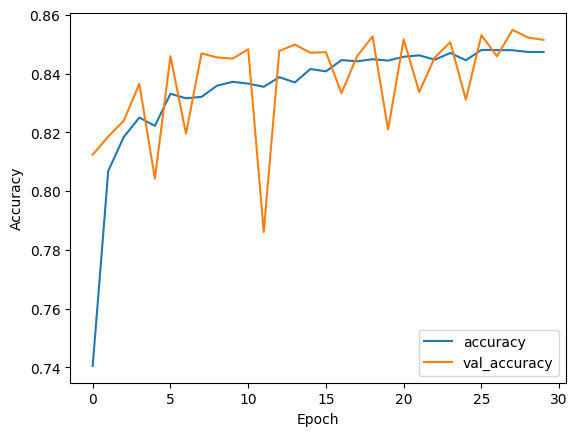

In [30]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/kaggle/working/best_model')

predictions = model.predict(X)
predicted_class = np.argmax(predictions[i])

for i in range(10):
    print(predictions[i], labels[i])

predicted_labels = (predicted_class > 0.5).astype(int)
accuracy = np.sum(predictions == (labels == "healthy")) / len(labels)

print("Accuracy:", accuracy)

## CNN

In [ ]:
def build_model(input_shape=input_shape, dropout_rate=0.4):
    tf.random.set_seed(seed)

    input_layer = tf.keras.Input(shape=input_shape, name='Input')

    conv1 = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=3,
        padding='same',
        activation='relu',
        kernel_initializer=tf.keras.initializers.HeUniform(seed)
    )(input_layer)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    pool1 = tf.keras.layers.MaxPooling2D()(conv1)
    pool1 = tf.keras.layers.Dropout(dropout_rate, seed=seed)(pool1)

    conv2 = tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=3,
        padding='same',
        activation='relu',
        kernel_initializer=tf.keras.initializers.HeUniform(seed)
    )(pool1)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    pool2 = tf.keras.layers.MaxPooling2D()(conv2)
    pool2 = tf.keras.layers.Dropout(dropout_rate, seed=seed)(pool2)

    conv3 = tf.keras.layers.Conv2D(
        filters=128,
        kernel_size=3,
        padding='same',
        activation='relu',
        kernel_initializer=tf.keras.initializers.HeUniform(seed)
    )(pool2)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    pool3 = tf.keras.layers.MaxPooling2D()(conv3)
    pool3 = tf.keras.layers.Dropout(dropout_rate, seed=seed)(pool3)

#    conv4 = tf.keras.layers.Conv2D(
#        filters=256,
#        kernel_size=3,
#        padding='same',
#        activation='relu',
#        kernel_initializer=tf.keras.initializers.HeUniform(seed)
#    )(pool3)
#    conv4 = tf.keras.layers.BatchNormalization()(conv4)
#    pool4 = tf.keras.layers.MaxPooling2D()(conv4)
#    pool4 = tf.keras.layers.Dropout(dropout_rate, seed=seed)(pool4)
    
    final_pool = pool3

    gap_layer = tf.keras.layers.GlobalAveragePooling2D(name='Gap')(final_pool)
    
    dropout = tf.keras.layers.Dropout(dropout_rate, seed=seed)(gap_layer)

    l1_strength = 0.0005
    l2_strength = 0.01
    
    # Use 1 unit for binary classification (2 classes)
    output_layer = tf.keras.layers.Dense(
        units=1,
        activation='sigmoid',  # Use 'sigmoid' for binary classification
        kernel_initializer=tf.keras.initializers.HeUniform(seed),
        name='output_layer',
        kernel_regularizer = tf.keras.regularizers.L1L2(l1=l1_strength, l2=l2_strength)
    )(dropout)

    # Define the learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0005,
        decay_steps=10000,
        decay_rate=0.9
    )
    
    # Use the learning rate schedule for the Adam optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    # Connect input and output through the Model class
    model = tf.keras.Model(
        inputs=input_layer,
        outputs=output_layer,
        name='model')

    # Compile the model with the customized optimizer
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=['accuracy'])

    # Return the model
    return model


In [ ]:
# Build the model and return a summary about it
model = build_model()
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

## Train the model

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history


# Validation

In [ ]:
# Define the RandomRotation layer
rotation = tf.keras.Sequential([
  tfkl.RandomRotation(0.3),
])

# Define the RandomFlip layer
flip = tf.keras.Sequential([
  tfkl.RandomFlip("vertical"),
])

X_test_1 = X_val
X_test_2 = rotation(X_val)
X_test_3 = flip(X_val)

true_labels = y_val

# Make predictions on each test set
predictions_1 = model.predict(X_test_1)
predictions_2 = model.predict(X_test_2)
predictions_3 = model.predict(X_test_3)

# Assuming binary classification, adjust if needed

best_accuracy_1 = 0.0
limit_1 = 0.0

for limit in range(100):
    predicted_labels_1 = (predictions_1 > (limit / 100.0)).astype(int)
    accuracy_1 = np.sum(predicted_labels_1 == true_labels) / len(true_labels)
    
    if (accuracy_1 < best_accuracy_1):
        continue
        
    best_accuracy_1 = accuracy_1
    limit_1 = (limit / 100.0)
        
best_accuracy_2 = 0.0
limit_2 = 0.0

for limit in range(100):
    predicted_labels_2 = (predictions_2 > (limit / 100.0)).astype(int)
    accuracy_2 = np.sum(predicted_labels_2 == true_labels) / len(true_labels)
    
    if (accuracy_2 < best_accuracy_2):
        continue
        
    best_accuracy_2 = accuracy_2
    limit_2 = (limit / 100.0)

best_accuracy_3 = 0.0
limit_3 = 0.0

for limit in range(100):
    predicted_labels_3 = (predictions_3 > (limit / 100.0)).astype(int)
    accuracy_3 = np.sum(predicted_labels_3 == true_labels) / len(true_labels)
    
    if (accuracy_3 < best_accuracy_3):
        continue
        
    best_accuracy_3 = accuracy_3
    limit_3 = (limit / 100.0)


print("Limit on Test Set 1:", limit_1)
print("Limit on Test Set 2:", limit_2)
print("Limit on Test Set 3:", limit_3)
        
predicted_labels_1 = (predictions_1 > limit_1).astype(int)
predicted_labels_2 = (predictions_2 > limit_2).astype(int)
predicted_labels_3 = (predictions_3 > limit_3).astype(int)

# Compare the results
accuracy_1 = np.sum(predicted_labels_1 == true_labels) / len(true_labels)
accuracy_2 = np.sum(predicted_labels_2 == true_labels) / len(true_labels)
accuracy_3 = np.sum(predicted_labels_3 == true_labels) / len(true_labels)

print("Accuracy on Test Set 1:", accuracy_1)
print("Accuracy on Test Set 2:", accuracy_2)
print("Accuracy on Test Set 3:", accuracy_3)


final_prediction = []

for i in range(len(predictions_1)):
    healthy_prediction = predicted_labels_1[i] + predicted_labels_2[i] + predicted_labels_3[i]
    
    if (healthy_prediction >= 2):
        final_prediction.append([1])
        
    else:
        final_prediction.append([0])
        
final_accuracy = np.sum(final_prediction == true_labels) / len(true_labels)

print("Accuracy of Final Prediction:", final_accuracy)

In [ ]:
import matplotlib.pyplot as plt

# N predictions to display
N = 10

# Output the first N predictions for each set
print("Predictions on Test Set 1:")
print(predictions_1[:N])

print("\nPredictions on Test Set 2:")
print(predictions_2[:N])

print("\nPredictions on Test Set 3:")
print(predictions_3[:N])

print("\nFinal Predictions:")
print(np.array(final_prediction[:N]))

# Create subplots
fig, axes = plt.subplots(1, N, figsize=(15, 5))

for i in range(N):
    # Plot the original image from X_val
    ax = axes[i]
    ax.imshow(X_val[i].astype(np.uint8))
    ax.set_title(y_val[i])
    ax.axis('off')

plt.tight_layout()
plt.show()


# Plot the training

In [ ]:
# Plot the training
plt.figure(figsize=(15, 5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

## K fold

In [ ]:
# Train the model
# Define the number of folds
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

# Initialize lists to store the results from each fold
all_train_loss = []
all_train_acc = []
all_val_loss = []
all_val_acc = []

initial_learning_rate = 0.0001
lr_schedule = tfk.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps = 10000,
    decay_rate = 0.9,
    staircase = True,
)

# Iterate over the folds
for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split the data into training and validation sets
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Build the model
    model = build_model(input_shape=X_train.shape[1:], output_shape=output_shape)

    # Compile the model with a custom learning rate
    model.compile(
        loss=tfk.losses.CategoricalCrossentropy(),
        optimizer=tfk.optimizers.Adam(learning_rate=lr_schedule),
        metrics=['accuracy']
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs = epochs,
        batch_size = batch_size,
        validation_data = (X_val, y_val),
        verbose = 1
    )

    # Evaluate on training set
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    all_train_loss.append(train_loss)
    all_train_acc.append(train_acc)

    # Evaluate on validation set
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    all_val_loss.append(val_loss)
    all_val_acc.append(val_acc)

# Print average results over all folds
print(f"Average Training Loss: {np.mean(all_train_loss)}")
print(f"Average Training Accuracy: {np.mean(all_train_acc)}")
print(f"Average Validation Loss: {np.mean(all_val_loss)}")
print(f"Average Validation Accuracy: {np.mean(all_val_acc)}")

# Plot the training

In [ ]:
# Plot the training
plt.figure(figsize=(15, 5))
plt.plot(history.history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()


# Save the model and create submission

In [ ]:
import os
import zipfile
from datetime import datetime
import tensorflow as tf
from os.path import basename

# Specify the name of the submission folder
submission_folder = "SubmissionModel"

# Save best epoch model
ft_model.save(os.path.join(submission_folder, "SubmissionModel"))

# Save the model.py file in the main directory
with open("model.py", "w") as model_file:
    model_file.write("""

import os
import tensorflow as tf

class model:
    def __init__(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, 'SubmissionModel'))

    def predict(self, X):
        X = X/255.0
        out = self.model.predict(X)
        out = tf.argmax(out, axis=-1)  # Shape [BS]
        return out

""")

# Create an empty metadata file in the main directory
open("metadata", "w").close()

# Get the current date and time
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y%m%d_%H%M%S")

# Create the zipfile with date and time in the name
zipfile_name = f"{submission_folder}_{formatted_datetime}.zip"

with zipfile.ZipFile(zipfile_name, 'w') as zip_file:
    # Add the entire "SubmissionModel" folder and its contents to the archive
    for foldername, subfolders, filenames in os.walk(submission_folder):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            arcname = os.path.relpath(file_path, submission_folder)

            if (foldername in ["SubmissionModel", "SubmissionModel/model", "SubmissionModel/model/variables", "SubmissionModel/variables"]):
                continue

            # print(foldername)
            print(file_path)

            zip_file.write(file_path, arcname)

    # Add other files to the archive (model.py and metadata)
    zip_file.write("model.py", arcname="model.py")
    zip_file.write("metadata", arcname="metadata")

print(zipfile_name)

### 